# Proyecto Procesamiento de Señales e Imágenes


## Reconocimiento de covid a partir de registros de tos

#### Cristóbal Álvarez - 202073090-3

#### Importación de librerías

In [1]:
#!pip install matplotlib
#%pip install librosa
#!pip install ffmpeg
#%pip install moviepy
#!pip install torchaudio
#!pip install pydub
#!pip install IPython
#!pip install pyaudio
#!pip install tensorflow
#!pip install PyAudioAnalysis
#!pip install eyed3

In [2]:
import numpy as np
import pandas as pd
import os
import math

import matplotlib.pyplot as plt

import moviepy.editor as mp

import torchaudio
import IPython
from IPython.display import Audio
from pydub import AudioSegment

import ffmpeg
import librosa
import librosa.display as librosa_display

import pyaudio
import random

import pywt

import tensorflow as tf

import imblearn

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, precision_recall_curve,confusion_matrix,precision_score, recall_score,average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression

from skimage.restoration import denoise_wavelet

from scipy import signal
from scipy.io import wavfile

from statsmodels.robust import mad

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler

from collections import Counter

from pyAudioAnalysis import ShortTermFeatures, MidTermFeatures

#### Funciones útiles

In [4]:
def grafico_barras_df(nombre_df):
    features = list(nombre_df.columns)
    histogram = [] # number of not NaN values

    for feature in features:
        histogram.append(nombre_df[feature].count())

    plt.bar(features, histogram)
    plt.xticks(range(len(features)), features, rotation='vertical', fontsize=6)
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.show()

#### Obtención y tratamiento de datos

Number of samples: 27550
Number of classes / features: 51


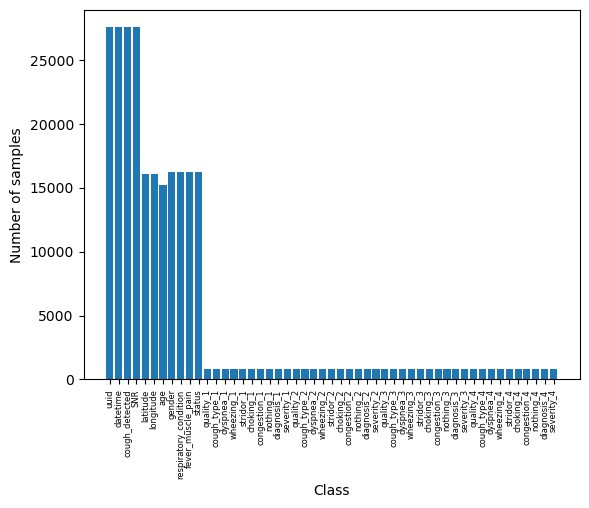

In [5]:
path_file = 'data/metadata_compiled.csv'
audio_files = pd.read_csv(path_file)

print("Number of samples: %d" % (len(audio_files)))
print("Number of classes / features: %d" % (len(audio_files.columns)))

grafico_barras_df(audio_files)

In [6]:
print(audio_files['diagnosis_4'].unique())

[nan 'upper_infection' 'obstructive_disease' 'lower_infection'
 'healthy_cough' 'COVID-19']


In [7]:
audio_files.dropna(subset=['status'], inplace=True)

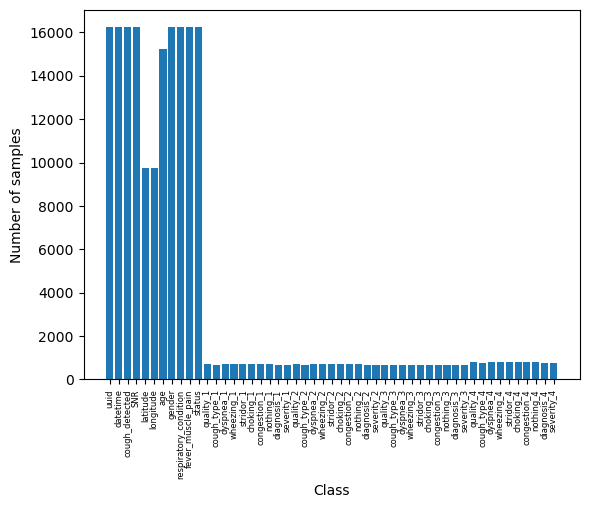

In [8]:
grafico_barras_df(audio_files)

In [9]:
audio_files = audio_files.query("cough_detected >= 0.7")

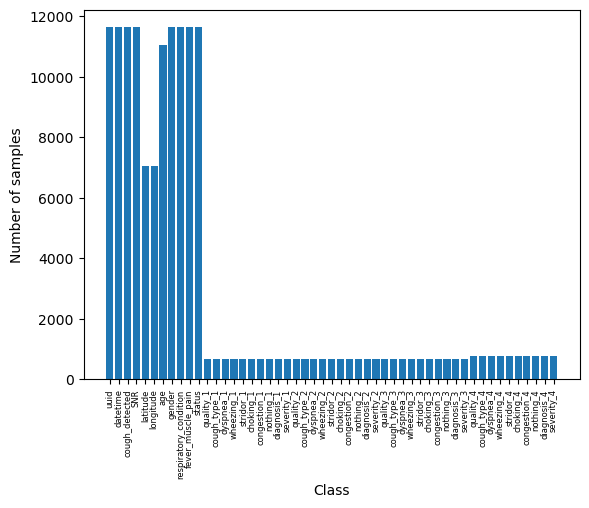

In [10]:
grafico_barras_df(audio_files)

In [11]:
datos_de_status = audio_files['status'].unique()
print(datos_de_status)

audio_files['Diagnostico'] = ''
audio_files.loc[audio_files['status'].isin(['healthy', 'symptomatic']), 'Diagnostico'] = 0
audio_files.loc[audio_files['status'] == 'COVID-19', 'Diagnostico'] = 1

['healthy' 'symptomatic' 'COVID-19']


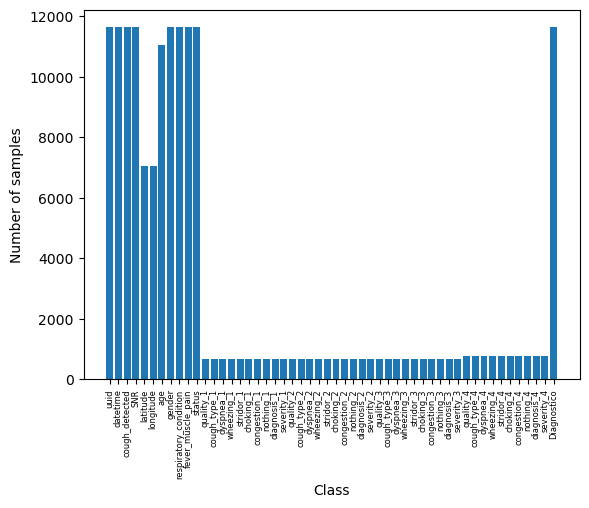

In [12]:
grafico_barras_df(audio_files)

In [13]:
datos_de_status = audio_files['Diagnostico'].unique()
print(datos_de_status)

[0 1]


In [14]:
print(audio_files['SNR'].value_counts())
audio_files.drop(audio_files[audio_files['SNR'] == np.inf].index, inplace=True)

SNR
0.000000     691
inf            4
20.175254      2
18.624818      2
20.723205      2
            ... 
45.606623      1
7.099749       1
21.505797      1
19.508512      1
14.162062      1
Name: count, Length: 10938, dtype: int64


### Eliminación de atributos no relevantes

Luego resulta necesario la eliminación de atributos que no son importantes para la predicción, dentro de estos encontramos datos como la fecha en que se toma el registro, datos geográficos como la latitud y la longitud y el status puesto que es reemplazado por el campo "diagnóstico"

In [15]:
audio_files = audio_files.drop(["status", "datetime", "latitude", "longitude", "age", "cough_detected"], axis = 1)

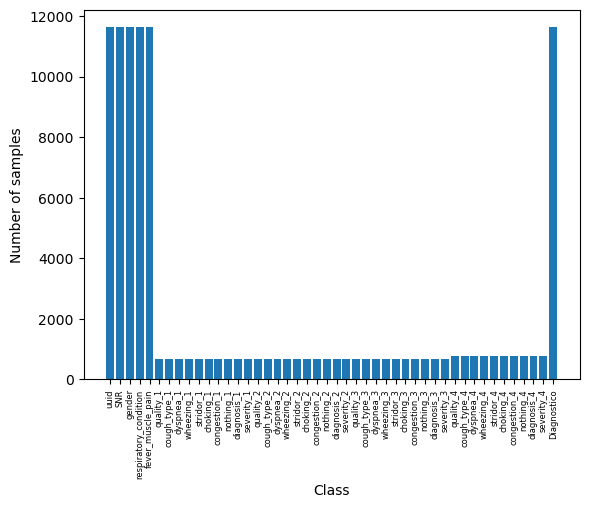

In [16]:
grafico_barras_df(audio_files)

### Solucionar multiples evaluaciones para un mismo dato

Se apreció que existen 110 datos que tienen comentarios médicos de más de un médico, el problema de esto es que no permite resumir en una columna por atributo (¿el comentario de cuál médico se mantendría?) ya que en estos 110 datos, los comentarios médicos no eran los mismos, uno categorizaba de una manera mientras otro categorizaba de otra. Lo que se hará es identificar estos 110 datos y eliminarlos.

In [17]:
wheezing_columns = ['wheezing_1', 'wheezing_2', 'wheezing_3', 'wheezing_4']

count = 0

valores = list()

fila = 0

# Iterar sobre cada una de las filas del dataframe
for index, row in audio_files.iterrows():
    # Iterar sobre cada una de las columnas wheezing_n
    for i, wheezing_n in enumerate(wheezing_columns):
        # Verificar si wheezing_n no es NaN
        if (math.isnan(row[wheezing_n]) != 1):
            # Iterar sobre cada una de las columnas wheezing_m
            for j, wheezing_m in enumerate(wheezing_columns):
                if i != j:
                    #Verificar si wheezing_m no es NaN
                    if (math.isnan(row[wheezing_m]) != 1):
                        count += 1
                        valores.append(fila)
                        break  
    fila += 1

valores = np.unique(valores)

print("Índices de los datos que tienen más de un comentario médico: ", valores)

# Print the count
print("Veces que un dato tiene más de un comentario médico: ", count/4)

Índices de los datos que tienen más de un comentario médico:  [   84   708   710  1346  1389  1490  1495  1811  1963  2034  2094  2160
  2168  2205  2231  2259  2296  2508  2610  3007  3275  3303  3360  3477
  3522  3678  3708  3756  3858  3879  3936  4148  4166  4189  4191  4427
  4489  4497  4541  4565  4573  4579  4789  4923  4931  4979  5034  5117
  5124  5284  5474  5587  5627  5720  5891  5901  5927  5929  5989  6191
  6238  6246  6264  6335  6497  6621  6649  6673  6911  6953  6988  7104
  7580  7683  7843  7872  7948  7954  8237  8264  8298  8315  8446  8480
  8513  8543  8604  8748  8831  8865  9088  9137  9286  9675  9741  9793
  9873  9877 10053 10075 10416 10418 10621 10743 10923 11127 11184 11217
 11334 11585]
Veces que un dato tiene más de un comentario médico:  110.0


In [18]:
print(audio_files.shape)

audio_files = audio_files.drop(audio_files.index[valores])

print(audio_files.shape)

(11630, 46)
(11520, 46)


Ahora, las filas restantes que contienen comentarios médicos tienen solo los de un médico, se eliminaron 110 filas que contenían comentarios de todos los médicos porque en varios casos existían evaluaciones distintas de entre ellos.

Lo que se pretende hacer ahora ya que cada fila con evaluación de médico tiene una evaluación solamente, se generará una columna única para cada tipo de evaluación (ej: en vez de quality_1, 2, 3, 4 existirá una sola llamada quality). 

In [19]:
import numpy as np

nombres_columnas_resumidas = ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']

for columna in nombres_columnas_resumidas:
    audio_files[columna] = ''


wheezing_columns = ['wheezing_1', 'wheezing_2', 'wheezing_3', 'wheezing_4']

count = 0


# Iterar sobre cada fila del dataframe
for index, row in audio_files.iterrows():
    # Iterar sobre cada columna de wheezing
    for i, wheezing_n in enumerate(wheezing_columns):
        # Verificar que el valor de la columna no sea NaN
        if (math.isnan(row[wheezing_n]) != 1):

            count += 1
            
            # Asignar los valores correspondientes a las columnas nuevas
            audio_files.at[index, 'quality'] = row['quality_' + str(i + 1)]
            audio_files.at[index, 'cough_type'] = row['cough_type_' + str(i + 1)]
            audio_files.at[index, 'dyspnea'] = row['dyspnea_' + str(i + 1)]
            audio_files.at[index, 'wheezing'] = row[wheezing_n]
            audio_files.at[index, 'stridor'] = row['stridor_' + str(i + 1)]
            audio_files.at[index, 'choking'] = row['choking_' + str(i + 1)]
            audio_files.at[index, 'congestion'] = row['congestion_' + str(i + 1)]
            audio_files.at[index, 'nothing'] = row['nothing_' + str(i + 1)]
            audio_files.at[index, 'diagnosis'] = row['diagnosis_' + str(i + 1)]
            audio_files.at[index, 'severity'] = row['severity_' + str(i + 1)]

            break
            
        else:
            # Mantener los NaN en la columna nueva
            audio_files.at[index, 'quality'] = row[wheezing_n]
            audio_files.at[index, 'cough_type'] = row[wheezing_n]
            audio_files.at[index, 'dyspnea'] = row[wheezing_n]
            audio_files.at[index, 'wheezing'] = row[wheezing_n]
            audio_files.at[index, 'stridor'] = row[wheezing_n]
            audio_files.at[index, 'choking'] = row[wheezing_n]
            audio_files.at[index, 'congestion'] = row[wheezing_n]
            audio_files.at[index, 'nothing'] = row[wheezing_n]
            audio_files.at[index, 'diagnosis'] = row[wheezing_n]
            audio_files.at[index, 'severity'] = row[wheezing_n]
            
        


In [20]:
print(count)

2390


Ahora hay que eliminar las columnas antiguas

In [21]:
columnas_antiguas = [   'quality_1', 'cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1', 'choking_1', 'congestion_1', 'nothing_1', 'severity_1', 'diagnosis_1',
                        'quality_2', 'cough_type_2', 'dyspnea_2', 'wheezing_2', 'stridor_2', 'choking_2', 'congestion_2', 'nothing_2', 'severity_2', 'diagnosis_2',
                        'quality_3', 'cough_type_3', 'dyspnea_3', 'wheezing_3', 'stridor_3', 'choking_3', 'congestion_3', 'nothing_3', 'severity_3', 'diagnosis_3',
                        'quality_4', 'cough_type_4', 'dyspnea_4', 'wheezing_4', 'stridor_4', 'choking_4', 'congestion_4', 'nothing_4', 'severity_4', 'diagnosis_4']

audio_files = audio_files.drop(columns=columnas_antiguas)

audio_files = audio_files.drop(columns='diagnosis')


In [22]:
audio_files


,uuid,SNR,gender,respiratory_condition,fever_muscle_pain,Diagnostico,quality,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,severity
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,16.151433,male,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,20.146058,male,True,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,13.146502,male,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,12.566406,male,True,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,13.477551,female,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27539,ffe0658f-bade-4654-ad79-40a468aabb03,21.960583,male,True,True,1,poor,unknown,False,False,False,False,False,False,unknown
27540,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,9.966762,male,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,33.661082,male,False,False,0,good,dry,False,False,False,False,False,True,pseudocough
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,9.635425,female,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


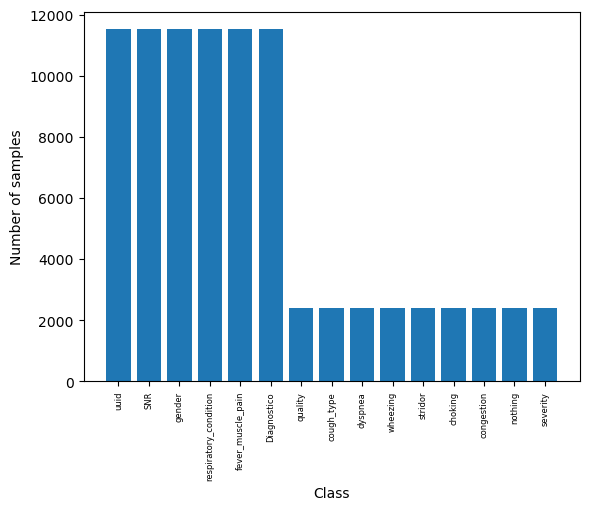

In [23]:
grafico_barras_df(audio_files)

### Conversión a valores numéricos

Únicamente se deja la columna uuid como no numérica para poder hacer el match con su respectivo archivo de audio

In [24]:
for col in audio_files.columns:
    n_unique = audio_files[col].value_counts()
    print(n_unique)

uuid
00039425-7f3a-42aa-ac13-834aaa2b6b92    1
ab77c2d6-edf7-4368-8cb1-5d8f1b928cef    1
ab802dfe-5c54-4d56-8126-654622be1519    1
ab808e5c-e74b-49fd-a52c-47b01e7d8cf6    1
ab81a6ab-e595-4196-bb0e-a10c9ed6d87a    1
                                       ..
55887c0d-1588-4475-8b7e-2577b2ffa068    1
559625c1-c5d6-4c0d-8e98-5e2a35a9f16e    1
5598bb27-ea8b-478e-acc7-ab40f250cf78    1
559d3196-444c-478f-9a69-1ffb1c05e643    1
fff13fa2-a725-49ef-812a-39c6cedda33d    1
Name: count, Length: 11520, dtype: int64
SNR
0.000000     686
20.175254      2
20.723205      2
18.624818      2
16.151433      1
            ... 
18.801389      1
17.614137      1
36.154189      1
7.369403       1
14.162062      1
Name: count, Length: 10832, dtype: int64
gender
male      7606
female    3852
other       62
Name: count, dtype: int64
respiratory_condition
False    9600
True     1920
Name: count, dtype: int64
fever_muscle_pain
False    10252
True      1268
Name: count, dtype: int64
Diagnostico
0    10823
1      69

In [25]:
'''
columnas = ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'severity']


for i in columnas:
    audio_files[i] = pd.to_numeric(audio_files[i], errors='coerce', downcast='float').fillna(0)
'''

"\ncolumnas = ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'severity']\n\n\nfor i in columnas:\n    audio_files[i] = pd.to_numeric(audio_files[i], errors='coerce', downcast='float').fillna(0)\n"

In [26]:
audio_files

,uuid,SNR,gender,respiratory_condition,fever_muscle_pain,Diagnostico,quality,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,severity
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,16.151433,male,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,20.146058,male,True,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,13.146502,male,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,12.566406,male,True,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,13.477551,female,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27539,ffe0658f-bade-4654-ad79-40a468aabb03,21.960583,male,True,True,1,poor,unknown,False,False,False,False,False,False,unknown
27540,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,9.966762,male,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,33.661082,male,False,False,0,good,dry,False,False,False,False,False,True,pseudocough
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,9.635425,female,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:

categorias_no_binarizables = ['quality', 'cough_type', 'severity']

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the selected columns
encoded_columns = encoder.fit_transform(audio_files[categorias_no_binarizables])

# Convert the encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(categorias_no_binarizables))

nombres_columnas_encoded = list(encoded_df.columns)

for columna in nombres_columnas_encoded:
    audio_files[columna] = encoded_df[columna]

columnas_nan = ['quality_nan', 'cough_type_nan', 'severity_nan', 'quality', 'cough_type', 'severity']

audio_files = audio_files.drop(columns=columnas_nan)


columnas = ['quality_good', 'quality_ok', 'quality_poor', 'cough_type_dry', 'cough_type_unknown', 'cough_type_wet', 'severity_mild', 'severity_pseudocough', 'severity_severe', 'severity_unknown']

for i in columnas:
    audio_files[i] = audio_files[i].replace({np.nan: 0})

audio_files



#audio_files.quality = audio_files.quality.replace({'poor': 0, 'ok': 1, 'good': 2})
#audio_files.cough_type = audio_files.cough_type.replace({'unknown': 0, 'wet': 1, 'dry': 2})
#audio_files.severity = audio_files.severity.replace({'unknown': 0, 'pseudocough': 1, 'mild': 2, 'severe': 3})



,uuid,SNR,gender,respiratory_condition,fever_muscle_pain,Diagnostico,dyspnea,wheezing,stridor,choking,...,quality_good,quality_ok,quality_poor,cough_type_dry,cough_type_unknown,cough_type_wet,severity_mild,severity_pseudocough,severity_severe,severity_unknown
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,16.151433,male,False,False,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,20.146058,male,True,False,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,13.146502,male,False,False,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,12.566406,male,True,False,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,13.477551,female,False,False,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27539,ffe0658f-bade-4654-ad79-40a468aabb03,21.960583,male,True,True,1,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27540,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,9.966762,male,False,False,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,33.661082,male,False,False,0,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,9.635425,female,False,False,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#Binarizado de variables booleanas

audio_files.dyspnea = audio_files.dyspnea.replace({True: 1, False: 0, np.nan: 0})
audio_files.wheezing = audio_files.wheezing.replace({True: 1, False: 0, np.nan: 0})
audio_files.stridor = audio_files.stridor.replace({True: 1, False: 0, np.nan: 0})
audio_files.choking = audio_files.choking.replace({True: 1, False: 0, np.nan: 0})
audio_files.congestion = audio_files.congestion.replace({True: 1, False: 0, np.nan: 0})
audio_files.nothing = audio_files.nothing.replace({True: 1, False: 0, np.nan: 0})


audio_files.fever_muscle_pain = audio_files.fever_muscle_pain.replace({True: 1, False: 0})
audio_files.respiratory_condition = audio_files.respiratory_condition.replace({True: 1, False: 0})
audio_files.Diagnostico = audio_files.Diagnostico.replace({True: 1, False: 0})


In [29]:
audio_files.drop(audio_files[audio_files['gender'] == 'other'].index, inplace=True)
audio_files.gender = audio_files.gender.replace({'male': 1, 'female': 0})

In [30]:
audio_files

,uuid,SNR,gender,respiratory_condition,fever_muscle_pain,Diagnostico,dyspnea,wheezing,stridor,choking,...,quality_good,quality_ok,quality_poor,cough_type_dry,cough_type_unknown,cough_type_wet,severity_mild,severity_pseudocough,severity_severe,severity_unknown
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,16.151433,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,20.146058,1,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,13.146502,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,12.566406,1,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,13.477551,0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27539,ffe0658f-bade-4654-ad79-40a468aabb03,21.960583,1,1,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27540,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,9.966762,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,33.661082,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,9.635425,0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
audio_files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11458 entries, 1 to 27544
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   11458 non-null  object 
 1   SNR                    11458 non-null  float64
 2   gender                 11458 non-null  int64  
 3   respiratory_condition  11458 non-null  int64  
 4   fever_muscle_pain      11458 non-null  int64  
 5   Diagnostico            11458 non-null  int64  
 6   dyspnea                11458 non-null  float64
 7   wheezing               11458 non-null  float64
 8   stridor                11458 non-null  float64
 9   choking                11458 non-null  float64
 10  congestion             11458 non-null  float64
 11  nothing                11458 non-null  float64
 12  quality_good           11458 non-null  float64
 13  quality_ok             11458 non-null  float64
 14  quality_poor           11458 non-null  float64
 15  cough_t

In [32]:
for col in audio_files.columns:
    n_unique = audio_files[col].value_counts()
    print(n_unique)

uuid
00039425-7f3a-42aa-ac13-834aaa2b6b92    1
abe8faaa-0cc9-4376-aec4-004f545db01e    1
ab8ad788-2f6c-489f-beb9-4057a6893dde    1
ab8ecc44-d33a-4e85-8e31-28cfe827fd17    1
ab9d35b9-d716-45b4-83bc-dbd614fe4b69    1
                                       ..
55cb1a15-6513-4602-8f59-ecdb5681248c    1
55cd3278-7993-4549-9a4a-7d453285a553    1
55d0ed26-a7a2-418d-b326-d0bd29a3f19c    1
55d74dca-c7b2-4788-b874-265b1047ed58    1
fff13fa2-a725-49ef-812a-39c6cedda33d    1
Name: count, Length: 11458, dtype: int64
SNR
0.000000     679
20.175254      2
20.723205      2
18.624818      2
17.585338      1
            ... 
11.620920      1
17.116883      1
12.781887      1
25.522020      1
14.162062      1
Name: count, Length: 10777, dtype: int64
gender
1    7606
0    3852
Name: count, dtype: int64
respiratory_condition
0    9562
1    1896
Name: count, dtype: int64
fever_muscle_pain
0    10203
1     1255
Name: count, dtype: int64
Diagnostico
0    10778
1      680
Name: count, dtype: int64
dyspnea
0.0  

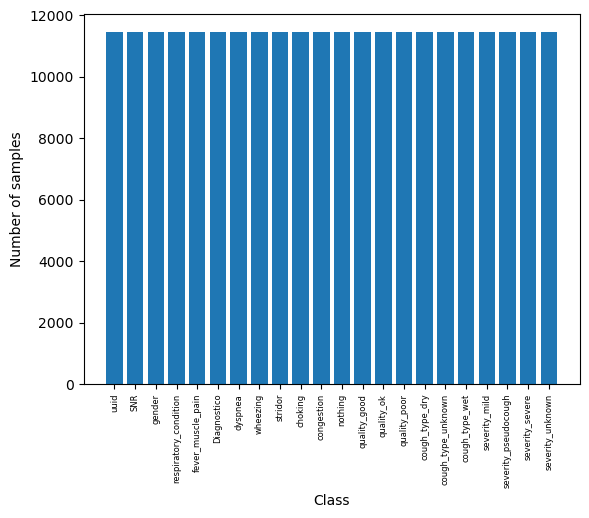

In [33]:
grafico_barras_df(audio_files)

In [34]:
#eliminar datos conflictivos (descomentar solo cuando se realiza la extracción de features de nuevo)
#shape mismatch: value array of shape (80,) could not be broadcast to indexing result of shape (27,)

#audio_files = audio_files.query("uuid != '64126506-0f32-4924-b36e-19f21adf22f6'")
#audio_files = audio_files.query("uuid != 'a1e4c73d-4754-4de0-a3ee-725dd650a226'")

## Procesamiento de audio

Ahora se debe pasar de los archivos de audio a un arreglo que contenga la información de la señal

Luego lo que hay que hacer es extraer información de la señal de audio y transformarla a un dataset.

In [35]:
def crear_df_features(features, uuid):
    
    datos = {}
    
    datos["uuid"] = [uuid]
    
    for i, elemento in enumerate(features):
        datos[f"columna_{i + 1}"] = [elemento]
    
    df = pd.DataFrame(datos)
    
    return df

In [36]:
#Eliminar el ruido de la señal
def eliminar_ruido(signal, mother_wavelet, method_used, mode_DWT, mode_trsh, level):
    denoised_signal = denoise_wavelet(signal, method=method_used, mode = mode_used, wavelet_levels=level, wavelet=mother_wavelet, rescale_sigma='True')
    
    return denoised_signal

def eliminar_ruido_wavelet(signal, mother_wavelet, level_used, mode_DWT, mode_thrs):
    
    coeficientesDWT = pywt.wavedec(signal, mother_wavelet, mode=mode_DWT, level=level_used)
    
    sigma = mad(coeficientesDWT[-1])
    
    thresholded = list()
    
    for i in coeficientesDWT:
        
        thresholded_signal = pywt.threshold(i, sigma*np.sqrt(2*np.log(len(coeficientesDWT))), mode=mode_thrs)
        
        thresholded_signal = np.array(thresholded_signal)
        
        thresholded.append(thresholded_signal)
    
    denoised_signal = pywt.waverec(thresholded, wavelet=mother_wavelet, mode=mode_DWT)
    
    return denoised_signal

def eliminar_ruido_wavelet2(signal, mother_wavelet, level_used, mode_DWT, mode_thrs, niv_deletion):
    
    coeficientesDWT = pywt.wavedec(signal, mother_wavelet, mode=mode_DWT, level=level_used)
    
    for i in range(1, niv_deletion):
        
        coeficientesDWT[-i] = np.zeros_like(coeficientesDWT[-i])
    
    denoised_signal = pywt.waverec(coeficientesDWT, wavelet=mother_wavelet, mode=mode_DWT)
    
    return denoised_signal
        

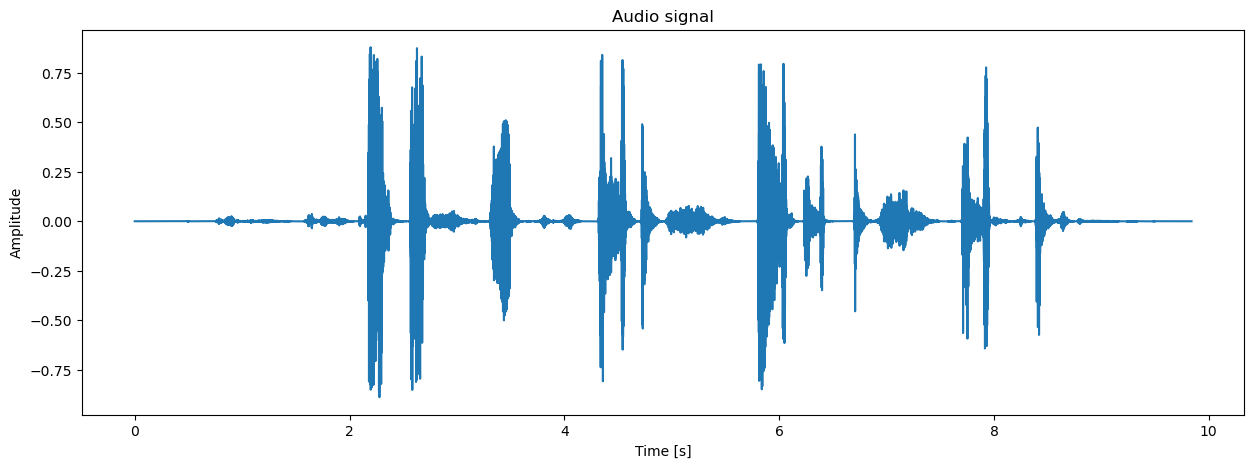

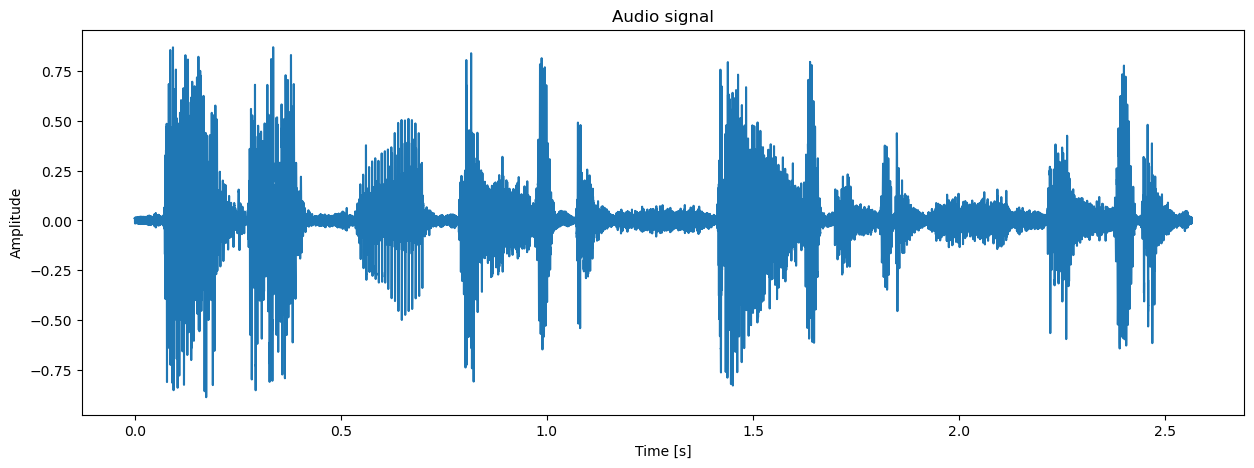

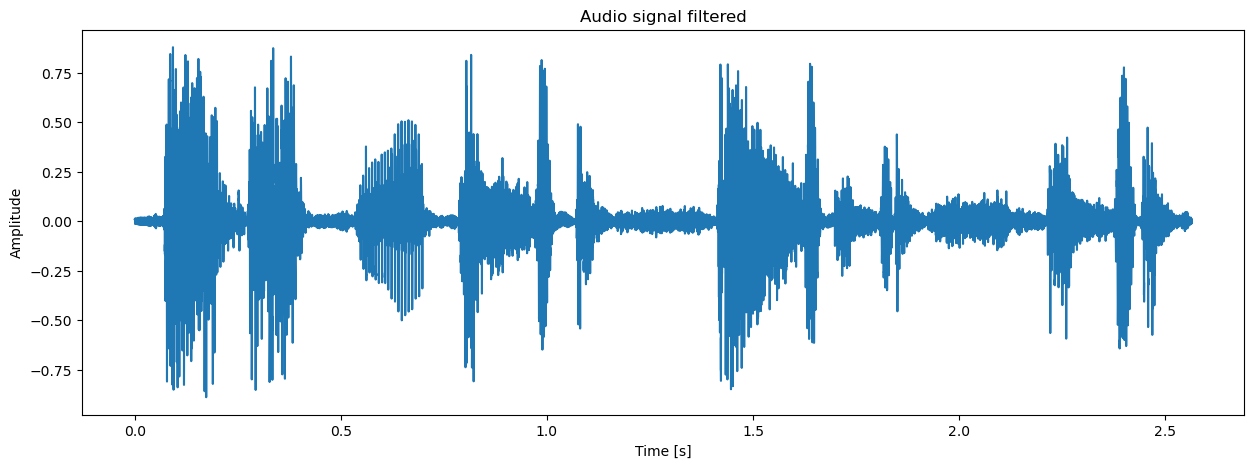

,uuid,columna_1,columna_2,columna_3,columna_4,columna_5,columna_6,columna_7,columna_8,columna_9,...,columna_21,columna_22,columna_23,columna_24,columna_25,columna_26,columna_27,columna_28,columna_29,columna_30
0,00ac8cb0-3384-46b2-9db5-5b5e911615f0,-223.403793,185.793991,-52.015518,-0.893162,-0.96683,-21.067327,9.990982,-13.76757,-15.296636,...,-4.177963,-5.395027,-1.92727,-5.132636,-3.384974,-2.261096,-2.290063,-2.161135,-1.812284,-1.494573


In [37]:
def convert_webm_to_wav(file_path):
    
    uuid = file_path
    
    file_path = "data/" + file_path + ".webm" 
    
    
    if not os.path.exists(file_path):
        #print("File not found")
        file_path = "data/" + uuid + ".ogg"
    '''
    else:
        #print("File found")
        continue
    '''

    t, sr = librosa.load(file_path, sr=None, mono=True, offset=0.0, duration=None, res_type='kaiser_fast')

    #print(t, sr)

    duration = t.shape[0] / sr

    time = np.linspace(0., duration, t.shape[0])
    
    
    plt.figure(figsize=(15, 5))
    plt.plot(time, t)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Audio signal")
    plt.show()
    
    #Eliminación arbitraria de donde no hay tos
    
    t = np.delete(t, np.where(abs(t) < 0.01))
    
    t2 = t
    
    t = eliminar_ruido_wavelet2(t, 'db8', 9, 'periodic', 'soft', 3)
    
    duration = t.shape[0] / sr

    time = np.linspace(0., duration, t.shape[0])
    
    
    plt.figure(figsize=(15, 5))
    plt.plot(time, t)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Audio signal")
    plt.show()
    
    plt.figure(figsize=(15, 5))
    plt.plot(time, t2)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Audio signal filtered")
    plt.show()
    

    IPython.display.display(IPython.display.Audio(t, rate=48000))
    
    mfccs_feature = librosa.feature.mfcc(y=t, sr=sr, n_mfcc=30)
    mfcc_scaled_feature=np.mean(mfccs_feature.T, axis=0)
    
    t_features = mfcc_scaled_feature
    
    #print(t_features)
    
    df = crear_df_features(t_features, uuid)
    
    #print(df.head(10))
    
    return df

convert_webm_to_wav("00ac8cb0-3384-46b2-9db5-5b5e911615f0")

In [38]:
def get_audio_file(file_path):
    
    uuid = file_path
    
    ###------Búsqueda del archivo dependiendo del formato------###
    
    file_path = "data/" + file_path + ".webm"     
    
    if not os.path.exists(file_path):
        #print("File not found")
        file_path = "data/" + uuid + ".ogg"
    '''
    else:
        #print("File found")
        continue
    '''
    
    ###------Lectura del archivo y carga en un arreglo------###
    
    t, sr = librosa.load(file_path, sr=None, mono=True, offset=0.0, duration=None, res_type='kaiser_fast')
    
    return t, sr


def noise_deletion_wavelet(signal, mother_wavelet, level_used, mode_DWT, mode_thrs, niv_deletion):
    
    ###------Extracción de los detalles y la aproximación------###
    
    coeficientesDWT = pywt.wavedec(signal, mother_wavelet, mode=mode_DWT, level=level_used)
    
    ###------Eliminación de niv_deletion detalles------###
    
    for i in range(1, niv_deletion):
        
        coeficientesDWT[-i] = np.zeros_like(coeficientesDWT[-i])
        
    ###------Reconstrucción de la señal------###
    
    denoised_signal = pywt.waverec(coeficientesDWT, wavelet=mother_wavelet, mode=mode_DWT)
    
    return denoised_signal    

In [39]:
'''
df = pd.DataFrame()

for uuid in audio_files["uuid"]:

    #Obtención del archivo de audio

    t, sr = get_audio_file(uuid)
    
    #Eliminación de momentos de silencio

    t = np.delete(t, np.where(abs(t) < 0.01))
    
    if(len(t) > 0):
    
        #Eliminación de ruido mediante wavelets

        t = noise_deletion_wavelet(t, 'db8', 9, 'periodic', 'soft', 3)

        #Extracción de features de la señal

        mfccs_feature = librosa.feature.mfcc(y=t, sr=sr, n_mfcc=20)

        #Normalización de las features

        mfcc_scaled_feature=np.mean(mfccs_feature.T, axis=0)

        t_features = mfcc_scaled_feature

        #Crear dataframe con las features de la señal

        df2 = crear_df_features(t_features, uuid)

        #Añadir información de la señal al dataframe con la info de todas las señales

        df = df._append(df2, ignore_index = True)
'''

'\ndf = pd.DataFrame()\n\nfor uuid in audio_files["uuid"]:\n\n    #Obtención del archivo de audio\n\n    t, sr = get_audio_file(uuid)\n    \n    #Eliminación de momentos de silencio\n\n    t = np.delete(t, np.where(abs(t) < 0.01))\n    \n    if(len(t) > 0):\n    \n        #Eliminación de ruido mediante wavelets\n\n        t = noise_deletion_wavelet(t, \'db8\', 9, \'periodic\', \'soft\', 3)\n\n        #Extracción de features de la señal\n\n        mfccs_feature = librosa.feature.mfcc(y=t, sr=sr, n_mfcc=20)\n\n        #Normalización de las features\n\n        mfcc_scaled_feature=np.mean(mfccs_feature.T, axis=0)\n\n        t_features = mfcc_scaled_feature\n\n        #Crear dataframe con las features de la señal\n\n        df2 = crear_df_features(t_features, uuid)\n\n        #Añadir información de la señal al dataframe con la info de todas las señales\n\n        df = df._append(df2, ignore_index = True)\n'

In [40]:
'''
df = pd.DataFrame()

cont = 1

for uuid in audio_files["uuid"]:
    
    if (cont % 100 == 0):
        
        print("iter: ", cont)
        

    #Obtención del archivo de audio

    t, sr = get_audio_file(uuid)

    #Eliminación de momentos de silencio

    t = np.delete(t, np.where(abs(t) < 0.01))

    duration = t.shape[0] / sr

    if(duration > 0.01):


        #Eliminación de ruido mediante wavelets

        t = noise_deletion_wavelet(t, 'db8', 9, 'periodic', 'soft', 3)

        #Extracción de features de la señal

        mf, sf, f_names = MidTermFeatures.mid_feature_extraction(t, sr, duration*sr, duration*sr, 0.01*sr, 0.005*sr)

        mf2 = mf[:34].reshape(1,34).tolist()
        f_names2 = f_names[:34]

        #Crear dataframe con las features de la señal

        df2 = pd.DataFrame(mf2, columns=f_names2)

        df2.insert(0, "uuid", [uuid], True)

        #Añadir información de la señal al dataframe con la info de todas las señales

        df = df._append(df2, ignore_index = True)
    
    cont += 1
'''

'\ndf = pd.DataFrame()\n\ncont = 1\n\nfor uuid in audio_files["uuid"]:\n    \n    if (cont % 100 == 0):\n        \n        print("iter: ", cont)\n        \n\n    #Obtención del archivo de audio\n\n    t, sr = get_audio_file(uuid)\n\n    #Eliminación de momentos de silencio\n\n    t = np.delete(t, np.where(abs(t) < 0.01))\n\n    duration = t.shape[0] / sr\n\n    if(duration > 0.01):\n\n\n        #Eliminación de ruido mediante wavelets\n\n        t = noise_deletion_wavelet(t, \'db8\', 9, \'periodic\', \'soft\', 3)\n\n        #Extracción de features de la señal\n\n        mf, sf, f_names = MidTermFeatures.mid_feature_extraction(t, sr, duration*sr, duration*sr, 0.01*sr, 0.005*sr)\n\n        mf2 = mf[:34].reshape(1,34).tolist()\n        f_names2 = f_names[:34]\n\n        #Crear dataframe con las features de la señal\n\n        df2 = pd.DataFrame(mf2, columns=f_names2)\n\n        df2.insert(0, "uuid", [uuid], True)\n\n        #Añadir información de la señal al dataframe con la info de todas 

In [41]:

#uuid = "a1e4c73d-4754-4de0-a3ee-725dd650a226"
'''
t, sr = get_audio_file(uuid)

t = np.delete(t, np.where(abs(t) < 0.01))

duration = t.shape[0] / sr

print(duration)

time = np.linspace(0., duration, t.shape[0])

plt.figure(figsize=(15, 5))
plt.plot(time, t)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Audio signal filtered")
plt.show()

mf, sf, f_names = MidTermFeatures.mid_feature_extraction(t, sr, duration*sr, duration*sr, 0.01*sr, 0.005*sr)
'''

'\nt, sr = get_audio_file(uuid)\n\nt = np.delete(t, np.where(abs(t) < 0.01))\n\nduration = t.shape[0] / sr\n\nprint(duration)\n\ntime = np.linspace(0., duration, t.shape[0])\n\nplt.figure(figsize=(15, 5))\nplt.plot(time, t)\nplt.xlabel("Time [s]")\nplt.ylabel("Amplitude")\nplt.title("Audio signal filtered")\nplt.show()\n\nmf, sf, f_names = MidTermFeatures.mid_feature_extraction(t, sr, duration*sr, duration*sr, 0.01*sr, 0.005*sr)\n'

In [42]:
'''
mf2 = mf[:34].reshape(1,34).tolist()
f_names2 = f_names[:34]


df = pd.DataFrame(mf2, columns=f_names2)

df.insert(0, "uuid", [uuid], True)

print(df)
'''

'\nmf2 = mf[:34].reshape(1,34).tolist()\nf_names2 = f_names[:34]\n\n\ndf = pd.DataFrame(mf2, columns=f_names2)\n\ndf.insert(0, "uuid", [uuid], True)\n\nprint(df)\n'

In [43]:
#df.to_csv('audio_features.csv')
#df.to_csv('nuevas_audio_features.csv')

#df.to_csv('audio_fetures2.csv')

#df

In [44]:
#df = pd.read_csv('audio_features.csv')
#df = pd.read_csv('nuevas_audio_features.csv')

df = pd.read_csv('audio_fetures2.csv')
#grafico_barras_df(df)

In [45]:
df

,Unnamed: 0,uuid,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,...,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean
0,0,00039425-7f3a-42aa-ac13-834aaa2b6b92,0.052844,0.037930,3.046646,0.130538,0.159236,0.583595,0.011401,0.107734,...,0.003858,0.007335,0.058530,0.001669,0.005344,0.008561,0.002320,0.046299,0.002278,0.023964
1,1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0.039656,0.063368,3.052200,0.117899,0.160061,0.342999,0.011457,0.070036,...,0.001582,0.011401,0.034199,0.000603,0.003044,0.040073,0.001284,0.055203,0.001208,0.027187
2,2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0.083160,0.020396,2.990103,0.139520,0.141957,0.793002,0.010439,0.127354,...,0.004234,0.006030,0.017802,0.001913,0.006880,0.014960,0.012784,0.032450,0.013638,0.015091
3,3,001e2f19-d81c-4029-b33c-d2db56b23a4a,0.037716,0.019435,3.058134,0.123310,0.165734,0.458978,0.013564,0.077083,...,0.001003,0.006011,0.058600,0.000801,0.003839,0.008719,0.002727,0.069555,0.002684,0.028489
4,4,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,0.087942,0.034711,3.112205,0.144898,0.146117,0.816765,0.008921,0.140086,...,0.007226,0.012090,0.011766,0.001452,0.007239,0.007895,0.006197,0.022140,0.020496,0.013403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,11544,ffe0658f-bade-4654-ad79-40a468aabb03,0.066206,0.102552,3.146209,0.131475,0.149483,0.760045,0.012627,0.121534,...,0.003239,0.008025,0.039021,0.002076,0.006341,0.013946,0.005260,0.042822,0.004668,0.018084
11545,11545,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,0.058292,0.020470,2.954866,0.131805,0.163274,0.485719,0.013420,0.089535,...,0.002677,0.004088,0.046714,0.001910,0.004396,0.009539,0.003178,0.060979,0.002366,0.025940
11546,11546,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,0.041773,0.091527,3.012324,0.121758,0.167649,0.350436,0.015005,0.066824,...,0.001146,0.008876,0.054171,0.000829,0.003931,0.018063,0.002756,0.044048,0.001876,0.027385
11547,11547,ffeea120-92a4-40f9-b692-c3865c7a983f,0.073047,0.027572,3.048824,0.132208,0.146043,0.804654,0.009191,0.131529,...,0.004120,0.016504,0.038353,0.002635,0.010855,0.012555,0.004483,0.030362,0.003385,0.017023


In [46]:
df.drop(columns='Unnamed: 0', inplace=True)
#grafico_barras_df(df)

In [47]:
nombres_columnas_featuresaudio = list(df.columns)

nombres_columnas_featuresaudio

['uuid',
 'zcr_mean',
 'energy_mean',
 'energy_entropy_mean',
 'spectral_centroid_mean',
 'spectral_spread_mean',
 'spectral_entropy_mean',
 'spectral_flux_mean',
 'spectral_rolloff_mean',
 'mfcc_1_mean',
 'mfcc_2_mean',
 'mfcc_3_mean',
 'mfcc_4_mean',
 'mfcc_5_mean',
 'mfcc_6_mean',
 'mfcc_7_mean',
 'mfcc_8_mean',
 'mfcc_9_mean',
 'mfcc_10_mean',
 'mfcc_11_mean',
 'mfcc_12_mean',
 'mfcc_13_mean',
 'chroma_1_mean',
 'chroma_2_mean',
 'chroma_3_mean',
 'chroma_4_mean',
 'chroma_5_mean',
 'chroma_6_mean',
 'chroma_7_mean',
 'chroma_8_mean',
 'chroma_9_mean',
 'chroma_10_mean',
 'chroma_11_mean',
 'chroma_12_mean',
 'chroma_std_mean']

## Definicion de datasets para cada modelo

Lo primero será separar el dataset de testing, el cual será común para cada uno de los modelos, debe corresponder a un dataset que contenga todos los datos necesarios para que el modelo que más atributos considera pueda funcionar, esto es, data de audio y data de evaluación médica.

In [48]:
audio_files_medical = audio_files

#audio_files_medical = audio_files_medical.dropna(subset=['quality_1', 'quality_2', 'quality_3', 'quality_4'], how='all')

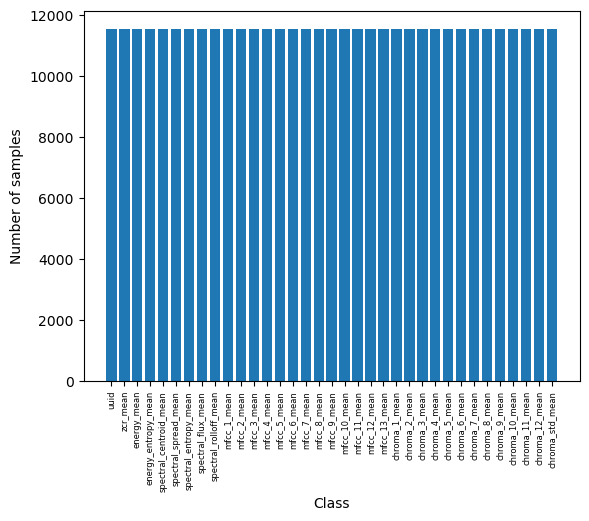

uuid                      11549
zcr_mean                  11419
energy_mean               11549
energy_entropy_mean       11549
spectral_centroid_mean    11549
spectral_spread_mean      11549
spectral_entropy_mean     11549
spectral_flux_mean        11548
spectral_rolloff_mean     11392
mfcc_1_mean               11549
mfcc_2_mean               11549
mfcc_3_mean               11549
mfcc_4_mean               11549
mfcc_5_mean               11549
mfcc_6_mean               11549
mfcc_7_mean               11549
mfcc_8_mean               11549
mfcc_9_mean               11549
mfcc_10_mean              11549
mfcc_11_mean              11549
mfcc_12_mean              11549
mfcc_13_mean              11549
chroma_1_mean             11549
chroma_2_mean             11549
chroma_3_mean             11549
chroma_4_mean             11549
chroma_5_mean             11549
chroma_6_mean             11549
chroma_7_mean             11549
chroma_8_mean             11549
chroma_9_mean             11549
chroma_1

In [49]:
grafico_barras_df(df)

print(df.nunique())

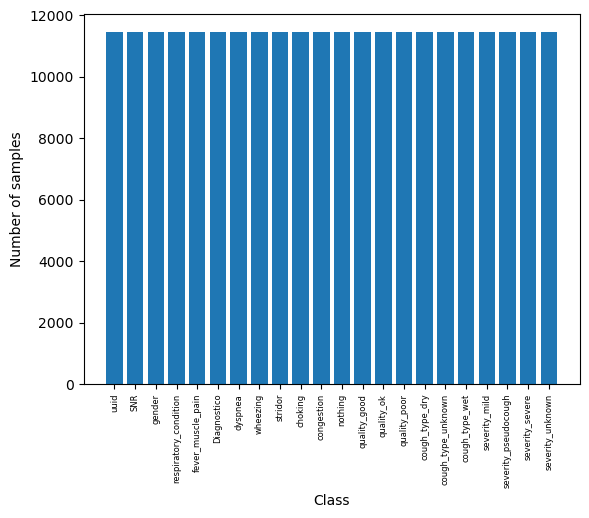

uuid                     11458
SNR                      10777
gender                       2
respiratory_condition        2
fever_muscle_pain            2
Diagnostico                  2
dyspnea                      2
wheezing                     2
stridor                      2
choking                      2
congestion                   2
nothing                      2
quality_good                 2
quality_ok                   2
quality_poor                 2
cough_type_dry               2
cough_type_unknown           2
cough_type_wet               2
severity_mild                2
severity_pseudocough         2
severity_severe              2
severity_unknown             2
dtype: int64


In [50]:
grafico_barras_df(audio_files_medical)

print(audio_files_medical.nunique())

In [51]:
#datos_de_status = audio_files['stridor_1'].unique()
#print(datos_de_status)

In [52]:
df_pre_testing = audio_files_medical.merge(df, on='uuid', how='inner')

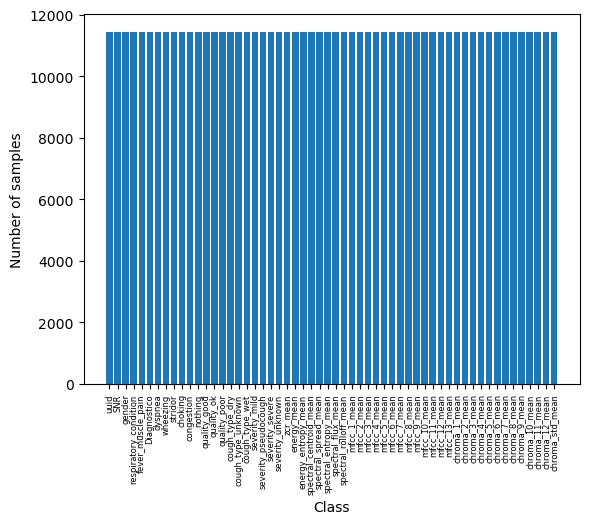

uuid                      11443
SNR                       10766
gender                        2
respiratory_condition         2
fever_muscle_pain             2
Diagnostico                   2
dyspnea                       2
wheezing                      2
stridor                       2
choking                       2
congestion                    2
nothing                       2
quality_good                  2
quality_ok                    2
quality_poor                  2
cough_type_dry                2
cough_type_unknown            2
cough_type_wet                2
severity_mild                 2
severity_pseudocough          2
severity_severe               2
severity_unknown              2
zcr_mean                  11313
energy_mean               11443
energy_entropy_mean       11443
spectral_centroid_mean    11443
spectral_spread_mean      11443
spectral_entropy_mean     11443
spectral_flux_mean        11442
spectral_rolloff_mean     11289
mfcc_1_mean               11443
mfcc_2_m

In [53]:
grafico_barras_df(df_pre_testing)

print(df_pre_testing.nunique())

for col in audio_files.columns:
    n_unique = audio_files[col].value_counts()
    print(n_unique)

De estos datos se extraerán 600 que conformarán el dataset de testing

In [54]:
print(df_pre_testing.shape[0])

11443


In [55]:
random_seed = 42
random.seed(random_seed)

#Mezclar el dataset
df_pre_testing = df_pre_testing.sample(frac=1)

df_testing = df_pre_testing.head(600)

df_no_testing = df_pre_testing.head(1900)

In [56]:
df_testing_x = df_testing.drop("Diagnostico", axis = 1)
df_testing_y = df_testing["Diagnostico"]

In [57]:
#grafico_barras_df(df_testing)

### Unión del dataset original y dataset de información registros sonoro

Una vez obtenido el dataset de testing, este no se tocará más hasta comparar los modelos, sin embargo, aún falta armar el dataset que servirá de base para los demás datasets que ocupan los distintos modelos. Para esto se deben eliminar del dataset "audio_files" todos los registros que corresponden al dataset de testing y también se debe hacer la unión entre este dataset y el obtenido de los registros sonoros

In [58]:
print(audio_files.shape[0])

11458


In [59]:
#Eliminar los elementos presentes en dataframe de testing
audio_files_filtrado = audio_files[~audio_files["uuid"].isin(df_testing["uuid"])]

#Unir este dataframe con el de características de los audios
audio_files = audio_files_filtrado.merge(df, on='uuid', how='inner')

In [60]:
#grafico_barras_df(audio_files)

In [61]:
print(audio_files.shape[0])

10843


#### Resultan 10843 datos con los que se podrán armar los demás datasets.

### Balanceo de clases

In [62]:
'''
x = audio_files.drop('Diagnostico', axis=1)
y = pd.DataFrame(audio_files.Diagnostico)

tl = RandomOverSampler(sampling_strategy='not minority')

x_tl, y_tl = tl.fit_resample(x,y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_tl))

print(y_tl.value_counts())
print(y.value_counts())
'''

"\nx = audio_files.drop('Diagnostico', axis=1)\ny = pd.DataFrame(audio_files.Diagnostico)\n\ntl = RandomOverSampler(sampling_strategy='not minority')\n\nx_tl, y_tl = tl.fit_resample(x,y)\n\nprint('Original dataset shape', Counter(y))\nprint('Resample dataset shape', Counter(y_tl))\n\nprint(y_tl.value_counts())\nprint(y.value_counts())\n"

## Dataframe para modelo predictor con información de audio exclusivamente

Todos los datos que quedan cuentan con información de los audios por lo que este dataset puede ser bastante grande sin problemas, basta con eliminar las columnas asociadas a los comentarios médicos.

In [63]:
df_audio = audio_files

columnas = ['quality_good', 'quality_ok', "quality_poor", 'cough_type_dry', 'cough_type_unknown', 'cough_type_wet', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'severity_mild', 'severity_pseudocough', 'severity_severe', 'severity_unknown', 'uuid']

#columnas = ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'severity', 'uuid']

df_audio = df_audio.drop(columns=columnas)

In [64]:
x1 = df_audio.drop('Diagnostico', axis=1)
y1 = pd.DataFrame(df_audio.Diagnostico)

n_cols1 = len(x1.axes[1])

In [65]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2, random_state=42)

ros = RandomOverSampler(random_state=42)

x1_train, y1_train = ros.fit_resample(x1_train, y1_train)

scaler = StandardScaler()

x1_train_scaled = scaler.fit_transform(x1_train)
x1_test_scaled= scaler.transform(x1_test)


### Clasificador con features de audio exclusivamente

In [66]:
model1 = Sequential([
    Dense(64, input_dim=n_cols1, activation='relu'),
    Dropout(0.12),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  #Para clasificación binaria
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#Entrenar el modelo base
model1.fit(x1_train_scaled, y1_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6332 - loss: 0.6438 - val_accuracy: 0.3224 - val_loss: 0.9294
Epoch 2/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7068 - loss: 0.5655 - val_accuracy: 0.6069 - val_loss: 0.6449
Epoch 3/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7367 - loss: 0.5163 - val_accuracy: 0.5772 - val_loss: 0.6965
Epoch 4/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7700 - loss: 0.4687 - val_accuracy: 0.5968 - val_loss: 0.6838
Epoch 5/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7947 - loss: 0.4414 - val_accuracy: 0.6959 - val_loss: 0.5808
Epoch 6/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8144 - loss: 0.3972 - val_accuracy: 0.7140 - val_loss: 0.5675
Epoch 7/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8381 - loss: 0.3619 - val_accuracy: 0.8718 - val_loss: 0.3639
Epoch 8/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8446 - loss: 0.3450 - val_accuracy: 0.

In [67]:
#Guardar el modelo base
model1.save('base_model1.keras')

### Evaluar el rendimiento del modelo

In [68]:
#Training set
y1_pred_train = model1.predict(x1_train_scaled)
y1_pred_train_binary = [int(round(p[0])) for p in y1_pred_train]
print("Métricas conjunto de entrenamiento:")
print(classification_report(y1_train, y1_pred_train_binary))

#Test set
y1_pred_test = model1.predict(x1_test_scaled)
y1_pred_test_binary = [int(round(p[0])) for p in y1_pred_test]
print("Métricas conjunto de pruebas")
print(classification_report(y1_test, y1_pred_test_binary))

511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Métricas conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      8172
           1       0.93      0.99      0.96      8172

    accuracy                           0.96     16344
   macro avg       0.96      0.96      0.96     16344
weighted avg       0.96      0.96      0.96     16344

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Métricas conjunto de pruebas
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      2031
           1       0.11      0.22      0.15       138

    accuracy                           0.83      2169
   macro avg       0.53      0.55      0.53      2169
weighted avg       0.89      0.83      0.86      2169



## Dataframe para modelo predictor con información médica exclusivamente

Para este dataframe se deben extraer aquellos datos que cuenten con comentarios médicos de alguno de los especialistas y las columnas asociadas a datos del registro sonoro.

In [69]:
df_medical = audio_files

columnas2 = nombres_columnas_featuresaudio

df_medical = df_medical.drop(columns=columnas2)

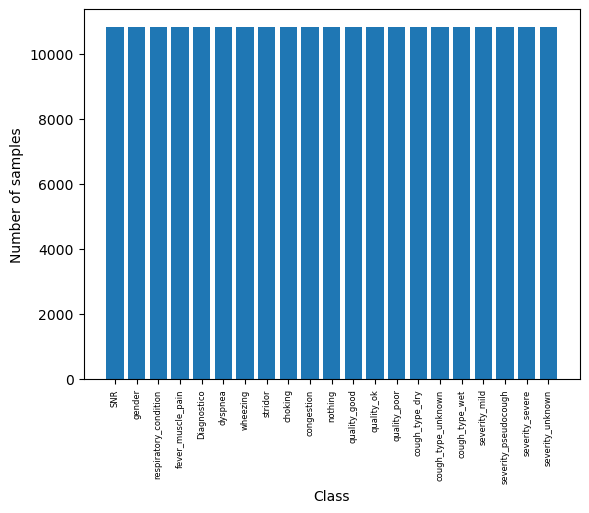

In [70]:
grafico_barras_df(df_medical)

In [71]:
'''for col in df_medical.columns:
    n_unique = df_medical[col].value_counts()
    print(n_unique)'''
    

'for col in df_medical.columns:\n    n_unique = df_medical[col].value_counts()\n    print(n_unique)'

In [72]:
x2 = df_medical.drop('Diagnostico', axis=1)
y2 = pd.DataFrame(df_medical.Diagnostico)

n_cols2 = len(x2.axes[1])

In [73]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state=42)

ros = RandomOverSampler(random_state=42)

x2_train, y2_train = ros.fit_resample(x2_train, y2_train)

scaler = StandardScaler()

x2_train_scaled = scaler.fit_transform(x2_train)
x2_test_scaled= scaler.transform(x2_test)

### Clasificador con información médica

In [74]:
#Modelo

model2 = Sequential([
    Dense(64, input_dim=n_cols2, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  #Para clasificación binaria
])

model2.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

#Entrenar el modelo base
model2.fit(x2_train_scaled, y2_train, epochs=6, batch_size=32, validation_split=0.2)

Epoch 1/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8533 - loss: 0.3702 - val_accuracy: 0.9547 - val_loss: 0.3719
Epoch 2/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8836 - loss: 0.3140 - val_accuracy: 0.9559 - val_loss: 0.3583
Epoch 3/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8788 - loss: 0.3153 - val_accuracy: 0.9523 - val_loss: 0.3751
Epoch 4/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8864 - loss: 0.2990 - val_accuracy: 0.9547 - val_loss: 0.2996
Epoch 5/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8860 - loss: 0.3050 - val_accuracy: 0.9529 - val_loss: 0.3310
Epoch 6/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8821 - loss: 0.3057 - val_accuracy: 0.9526 - val_loss: 0.3304


In [75]:
#Guardar el modelo base
model2.save('base_model.keras')

### Evaluar rendimiento del modelo

In [76]:
from sklearn.metrics import confusion_matrix

#Training set
y2_pred_train = model2.predict(x2_train_scaled)
y2_pred_train_binary = [int(round(p[0])) for p in y2_pred_train]
print("Métricas conjunto de entrenamiento:")
print(classification_report(y2_train, y2_pred_train_binary))

#Test set
y2_pred_test = model2.predict(x2_test_scaled)
y2_pred_test_binary = [int(round(p[0])) for p in y2_pred_test]
print("Métricas conjunto de pruebas")
print(classification_report(y2_test, y2_pred_test_binary))

confusion_matrix(y2_test, y2_pred_test_binary)

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Métricas conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      8172
           1       0.86      0.95      0.90      8172

    accuracy                           0.90     16344
   macro avg       0.90      0.90      0.90     16344
weighted avg       0.90      0.90      0.90     16344

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Métricas conjunto de pruebas
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      2031
           1       0.26      0.91      0.41       138

    accuracy                           0.83      2169
   macro avg       0.63      0.87      0.66      2169
weighted avg       0.95      0.83      0.87      2169



array([[1681,  350],
       [  12,  126]], dtype=int64)

## Dataframe para modelo predictor con información médica y de audio

Se eliminan todos los registros que no tienen evaluaciones médicas

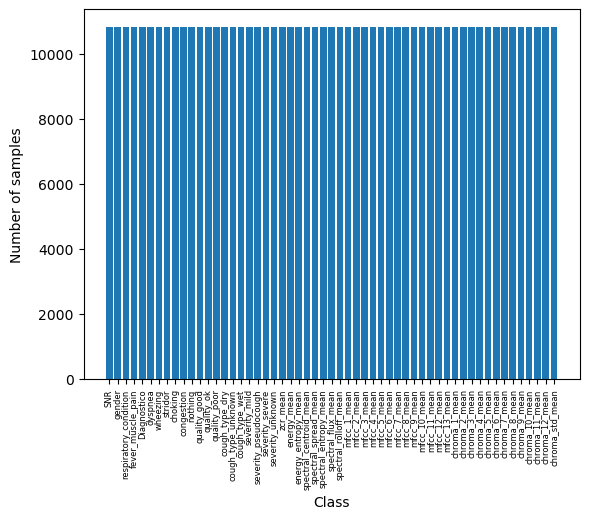

In [77]:
df_mixed = audio_files

df_mixed.drop(columns='uuid', inplace=True)

features = list(df_mixed.columns)
histogram = [] # number of not NaN values

for feature in features:
    histogram.append(df_mixed[feature].count())

plt.bar(features, histogram)
plt.xticks(range(len(features)), features, rotation='vertical', fontsize=6)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.show()

In [78]:
x3 = df_mixed.drop('Diagnostico', axis=1)
y3 = pd.DataFrame(df_mixed.Diagnostico)

n_cols3 = len(x3.axes[1])

In [79]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size = 0.2, random_state=42)

ros = RandomOverSampler(random_state=42)

x3_train, y3_train = ros.fit_resample(x3_train, y3_train)

scaler = StandardScaler()

x3_train_scaled = scaler.fit_transform(x3_train)
x3_test_scaled= scaler.transform(x3_test)

### Clasificador con todas las features disponibles

In [80]:
#Modelo

model3 = Sequential([
    Dense(64, input_dim=n_cols3, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  #Para clasificación binaria
])

model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#Entrenar el modelo base
model3.fit(x3_train_scaled, y3_train, epochs=6, batch_size=32, validation_split=0.2)

Epoch 1/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6968 - loss: 0.5496 - val_accuracy: 0.9605 - val_loss: 0.2452
Epoch 2/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8833 - loss: 0.2937 - val_accuracy: 0.9636 - val_loss: 0.2716
Epoch 3/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8887 - loss: 0.2748 - val_accuracy: 0.9633 - val_loss: 0.2381
Epoch 4/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8902 - loss: 0.2648 - val_accuracy: 0.9719 - val_loss: 0.2112
Epoch 5/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8930 - loss: 0.2574 - val_accuracy: 0.9682 - val_loss: 0.2186
Epoch 6/6
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8954 - loss: 0.2447 - val_accuracy: 0.9804 - val_loss: 0.1975


In [81]:
#Guardar el modelo base
model3.save('base_model.keras')

### Evaluar rendimiento del modelo

In [82]:
#Training set
y3_pred_train = model3.predict(x3_train_scaled)
y3_pred_train_binary = [int(round(p[0])) for p in y3_pred_train]
print("Métricas conjunto de entrenamiento:")
print(classification_report(y3_train, y3_pred_train_binary))

#Test set
y3_pred_test = model3.predict(x3_test_scaled)
y3_pred_test_binary = [int(round(p[0])) for p in y3_pred_test]
print("Métricas conjunto de pruebas")
print(classification_report(y3_test, y3_pred_test_binary))

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Métricas conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8172
           1       0.88      0.98      0.93      8172

    accuracy                           0.93     16344
   macro avg       0.93      0.93      0.93     16344
weighted avg       0.93      0.93      0.93     16344

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Métricas conjunto de pruebas
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      2031
           1       0.28      0.86      0.43       138

    accuracy                           0.85      2169
   macro avg       0.64      0.86      0.67      2169
weighted avg       0.94      0.85      0.88      2169

